In [1]:
import numpy             as np
import multiprocessing   as mp
import matplotlib.pyplot as plt
import gym
import Portfolio_Gym
import A2C_X as A2C
import Wrapper

'''
Be sure to install the latest Gym environments on your local machine. 
Navigate to .../rl-portfolio/Gym Environments/Portfolio_Management/
and run the command:
pip install -e .
'''


Instructions for updating:
non-resource variables are not supported in the long term


'\nBe sure to install the latest Gym environments on your local machine. \nNavigate to .../rl-portfolio/Gym Environments/Portfolio_Management/\nand run the command:\npip install -e .\n'

In [2]:
''' Settings & descriptions for the AC Agent '''

'''
    Actor_Hypers & Critic_Hypers | dict
        'Learning Rate' | float, list | The learning rate of the Actor.
        'Epoch'         | int         | The number of times each observation passes through the network.
        'Network Size'  | int         | The size of the Actor NN
        'Activation'    | string      | The activation of the Actor. Acceptable inputs include ['Relu', 'Sigmoid', 'Tanh', 'Softplus']
        'Batch Size'    | int         | The number of observations which pass through the network in each pass.
        'Alpha'         | float       | L2 regularization coefficient for the Actor.
 
     Gamma | float
        The discount rate for reward recieved by the agent.

    Sigma_Range | list
        A list of two floats, the first gives the starting sigma, and the last giving the terminal sigma. Sigma here referes to the sigma of the policy.

    Sigma_Anneal | float
        The fraction of training episodes which must pass before sigma decays to its terminal value.

    Retrain_Frequency | int
        The number of episodes between refits of the Actor and Critic

    Action_Space_Clip | float
        The value at which to clip the levergae the agent can take, to prevent it from randomly acting too agressively.

    Experiance_Mode | string
        A key which indicates the method to be used to generate experiance targets. Acceptable inputs include: ['Monte_Carlo', 'TD_1', 'TD_Lambda']

    TD_Lambda | float, list
        The lambda to use if using Experiance_Mode 'TD_Lambda'. If a float is passes lambda is constant. If a list of length 3 is passed then Lambda will fall from the 0th value to the 1st value, and will take the 2nd value fraction of training episodes to do so. i.e. by default will fall from 1 to 0.8 across 0.5 of the training episodes. A value of 1 is equivalent to Monte_Carlo, and a value of zero is equivalent to TD_1.

    Monte_Carlo_Frac | float
        The fraction of episodes to run overwriting Experiance_Mode with 'Monte_Carlo', as this method is most stable when the critic is poorly trained at the start of the training sequence.

    Ignore_Actor_Frac | float
        The fraction of episodes to train only Critic. Prevents the Actor being trained on nonsense at the start of training.
'''


'''
Reading the plots:
In order from left to right the plots represent:
    1. The critic prediction vs wealth, taken at 5 snapshots equally spaced throughout training. 
       The black curve represents the true utility function which the critic should approximate.
       
    2. Action vs wealth, taken at 5 snapshots equally spaced throughout training. Ideally this should be a horizontal line, 
       as wealth should not impact leverage, however this plot generated with the factor at its stationary point, and the 
       relation could change dramatically as the factor value fluctuates.
       
    3. Actor vs Factor, taken at 5 snapshots equally spaced throughout training. Ideally should see a linear relation with 
       positive gradient. 
       
    4. The Mu of the policy vs training episode. (Note this is not the action taken, but instead the action the agent thinks is optimal)
       A widening spread in this plot indicates that the agent is adjusting its action based upon variations in the state parameters, which
       is the desired behaviour. A thin line indicates the action is independent of state parameters.
       
    5. Agent terminal utility vs merton terminal utility. Recalculated every 10,000 steps. Represents the agents performance were exploration 
       rate set to zero.
       
    6. Fraction of actions which are within 10% of the merton action. 
'''
pass

In [5]:

# Model Parameters.
N_Eps  = int(1e5)

Actor_Hypers   = {"Learning Rate" : 0.005,
                  "Epoch"         : 1,
                  "Network Size"  : [8,4],
                  "Activation"    : "Sigmoid",
                  "Batch Size"    : 60,
                  "Alpha"         : 0.1}

Critic_Hypers = {"Learning Rate" : 0.005,
                 "Epoch"         : 10,
                 "Network Size"  : [8,4],
                 "Activation"    : "Sigmoid",
                 "Batch Size"    : 60,
                 "Alpha"         : 0.1}


# Function to facilitate mulitprocessing.
def Run(seed):
    np.random.seed(seed)
    Env = gym.make('Simulated-v1')
    Env.Set_Params(Factor_Beta = Factor_Beta, Asset_Beta = Asset_Beta, Cov = Cov, Period = 0.25, Max_Leverage = 100, Min_Leverage = -100)
        
    myAC = A2C.Actor_Critic(Env, Actor_Hypers, Critic_Hypers, Gamma = 0.999, Sigma_Range = [2, 0.5], Sigma_Anneal = 1, 
                            Retrain_Frequency = 20, Action_Space_Clip = 75, Experiance_Mode = 'TD_Lambda', TD_Lambda = 0.50, Monte_Carlo_Frac = 0.2)
    
    myWrapper = Wrapper.Wrapper(myAC)
    myWrapper.Train(N_Eps, Plot = ['Mu', 'Merton_Benchmark', 'Percent_Merton_Action', 'VAR_Benchmark'])
    return None


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
100%|█████████▉| 99881/100000 [16:23<00:01, 118.27it/s]

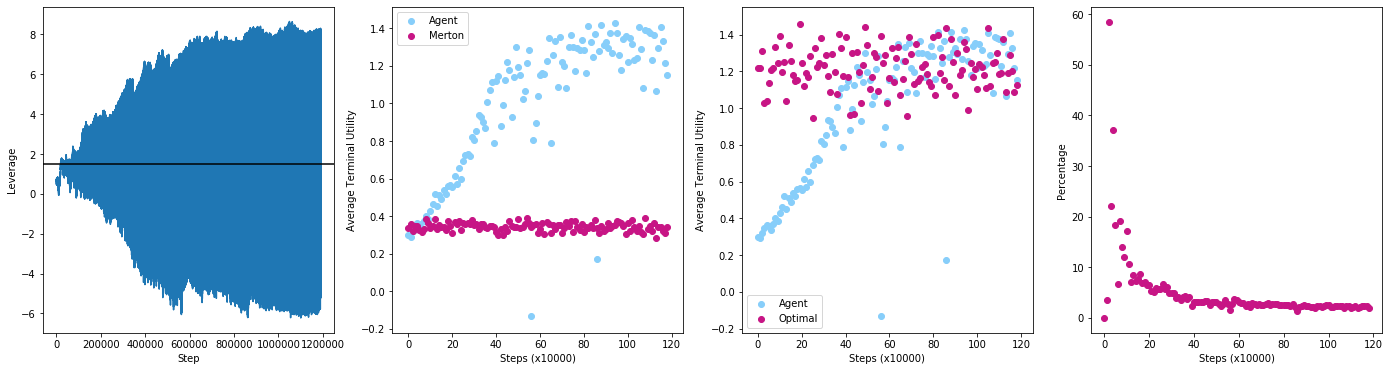

100%|██████████| 100000/100000 [16:24<00:00, 101.61it/s]


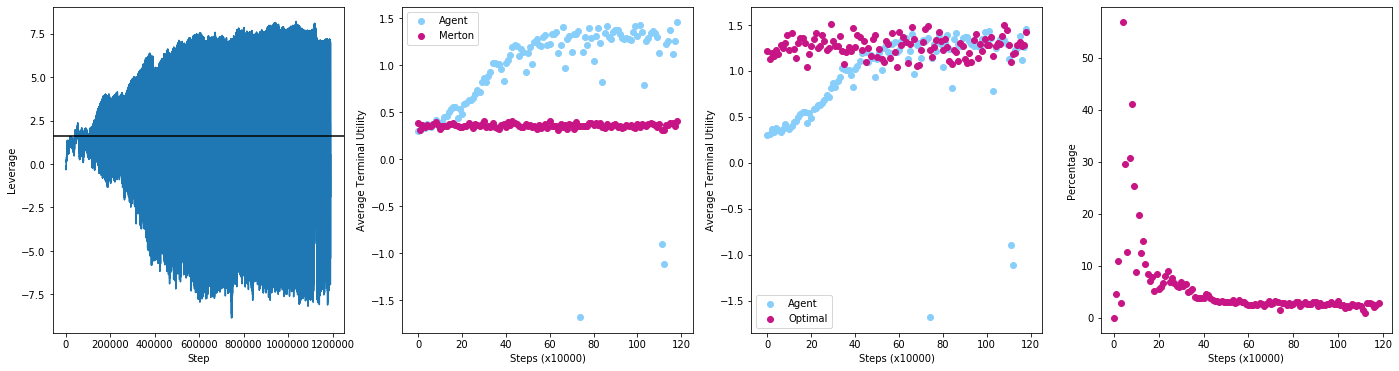

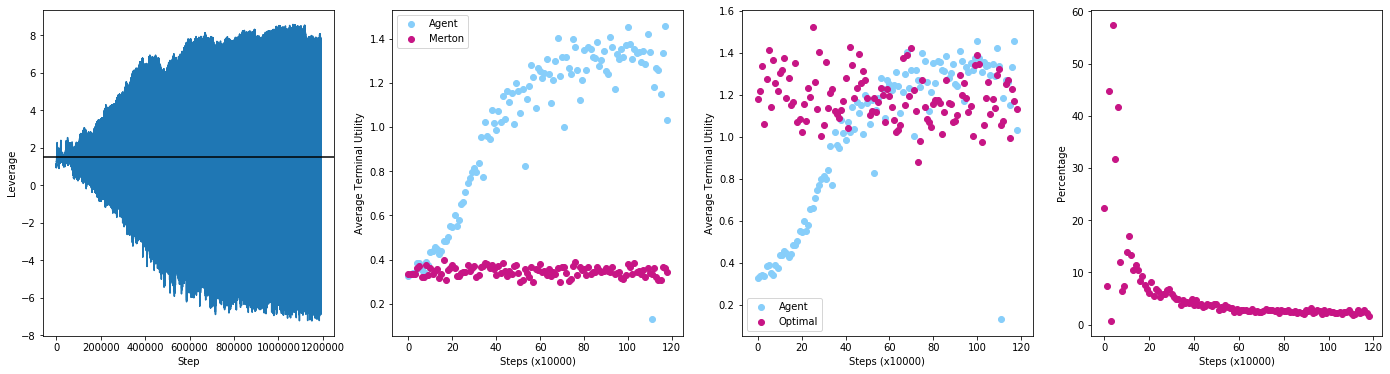

In [6]:
''' 
Simulated environment, using a high R2 Factor (Approx 0.2)        
'''

# Brandt Parameters with high R2 Asset
Factor_Beta = np.array([-0.1694, 0.9514]).reshape(-1,1)
Asset_Beta  = np.array([0.5549, 0.1568]).reshape(-1,1)
Cov         = np.array([[6.225, -6.044], [-6.044, 6.316]]) * 1e-3

# Run the investigation...
with mp.Pool(mp.cpu_count()) as pool:
    _ = pool.map(Run, np.random.randint(0, int(1e9), 3))



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
 99%|█████████▉| 99281/100000 [15:40<00:06, 109.26it/s]

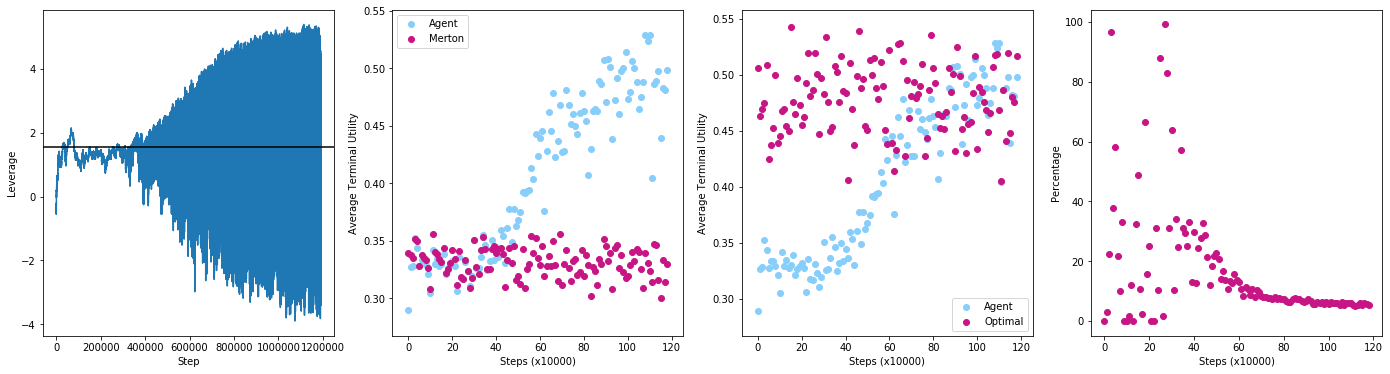

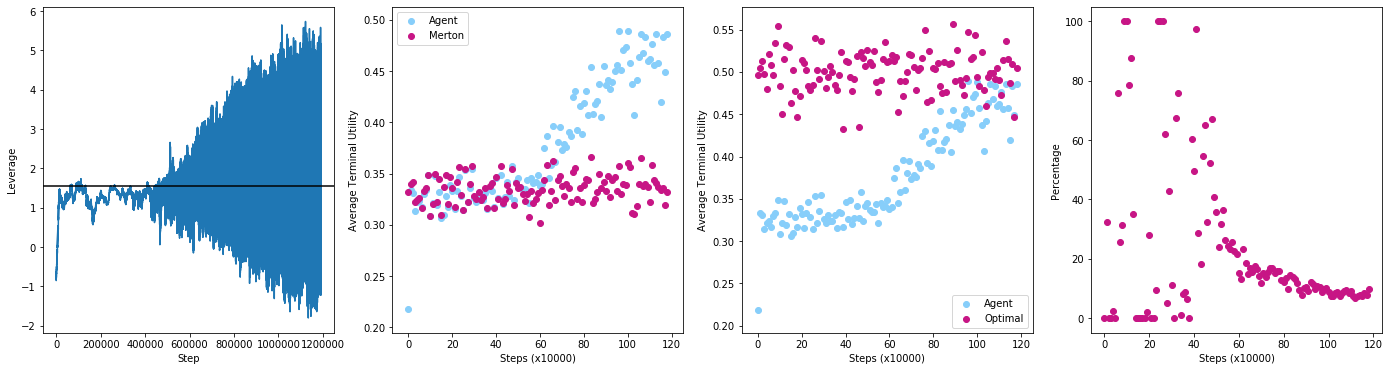

100%|██████████| 100000/100000 [15:46<00:00, 105.65it/s]


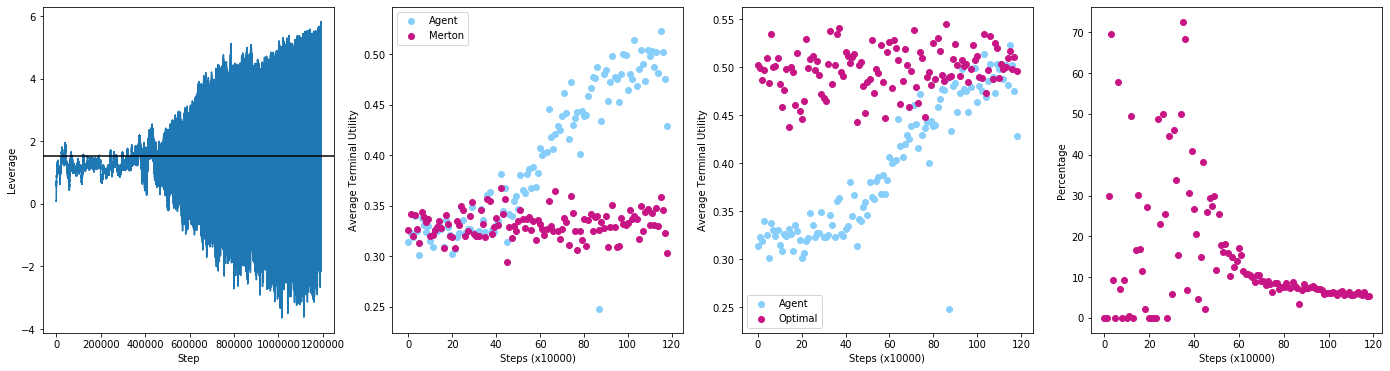

In [7]:
''' 
Simulated environment, using a realisitic factor per 'Portfolio Choice Problems' by Brandt. (R2 about 0.033)
'''

# Brandt Parameters
Factor_Beta = np.array([-0.1694, 0.9514]).reshape(-1,1)
Asset_Beta  = np.array([0.2049, 0.0568]).reshape(-1,1)
Cov         = np.array([[6.225, -6.044], [-6.044, 6.316]]) * 1e-3

# Run the investigation...
with mp.Pool(mp.cpu_count()) as pool:
    _ = pool.map(Run, np.random.randint(0, int(1e9), 3))


In [ ]:
# Run the historical version - Still needs tuning, preferably on a Sim with mutliple low R2 factors.
def Run_Hist(seed):
    np.random.seed(seed)
    Env = gym.make('Historical-v0')
    Env.Set_Params(Max_Leverage = 100, Min_Leverage = -100)
        
    myAC = A2C.Actor_Critic(Env, Actor_Hypers, Critic_Hypers, Gamma = 0.999, Sigma_Range = [2, 0.5], Sigma_Anneal = 1, 
                            Retrain_Frequency = 20, Action_Space_Clip = 75, Experiance_Mode = 'TD_Lambda', TD_Lambda = 0.50, Monte_Carlo_Frac = 0.2)
    
    myWrapper = Wrapper.Wrapper(myAC)
    myWrapper.Train(N_Eps, Plot = ['Mu', 'Merton_Benchmark', 'Percent_Merton_Action'], Validate = True)
    
    return None

# Run the investigation...
with mp.Pool(mp.cpu_count()) as pool:
    _ = pool.map(Run_Hist, np.random.randint(0, int(1e9), 3))
